# 1.5 「ファインチューニング」で精度向上を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、ファインチューニングでアリとハチの画像を分類するモデルを学習します



# 学習目標

1.	PyTorchでGPUを使用する実装コードを書けるようになる
2.	最適化手法の設定において、層ごとに異なる学習率を設定したファインチューニングを実装できるようになる
3.	学習したネットワークを保存・ロードできるようになる



# 事前準備

- 1.4節で解説したAWS EC2 のGPUインスタンスを使用します


In [1]:
# パッケージのimport
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [2]:
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 True


In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size = 32

In [5]:
OUTPUT_FEATURES = 2

MODEL_CATEGORY = 'VGG'

OPTIMIZER_TYPE = 'Adam'
LEARNING_RATIO = 0.001
MOMENTUM = 0.0
WEIGHT_DECAY = 1e-6

NUM_EPOCHS = 30

# MLflow

In [6]:
import mlflow

In [7]:
# experimentの作成(読み込み)
experiment_id = mlflow.set_experiment(MODEL_CATEGORY)  # experimentの設定. 無ければ新規に作成.
print(experiment_id.experiment_id)

2023/03/21 17:06:32 INFO mlflow.tracking.fluent: Experiment with name 'VGG' does not exist. Creating a new experiment.


855311499596505003


# DatasetとDataLoaderを作成

In [8]:
# 1.3節で作成したクラスを同じフォルダにあるmake_dataset_dataloader.pyに記載して使用
from utils.dataloader_image_classification import (
    HymenopteraDataset,
    ImageTransform,
    make_datapath_list,
)

# アリとハチの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Datasetを作成する
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
)


# DataLoaderを作成する
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


# モデルを学習させる関数を作成

In [9]:
def plot_history(name, history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    axes[0].plot(
        range(len(history["train"]["loss"])),
        history["train"]["loss"],
        "r-o",
        label=f"{name}-train",
    )
    axes[0].plot(
        range(len(history["val"]["loss"])),
        history["val"]["loss"],
        "b--s",
        label=f"{name}-val",
    )
    axes[0].set_xlabel("Epochs", size=14)
    axes[0].set_ylabel("Loss", size=14)
    axes[0].tick_params(labelsize=12)
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(
        range(len(history["train"]["acc"])),
        history["train"]["acc"],
        "r-o",
        label=f"{name}-train",
    )
    axes[1].plot(
        range(len(history["val"]["acc"])),
        history["val"]["acc"],
        "b--s",
        label=f"{name}-val",
    )
    axes[1].set_xlabel("Epochs", size=14)
    axes[1].set_ylabel("Accuracy", size=14)
    axes[1].tick_params(labelsize=12)
    axes[1].grid()
    axes[1].legend()
    plt.suptitle(f"{name}", size=16)
    # plt.show()
    return fig

In [10]:
def train_model(name, net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    history = {}
    history["train"] = {}
    history["val"] = {}
    history["train"]["loss"] = []
    history["train"]["acc"] = []
    history["val"]["loss"] = []
    history["val"]["acc"] = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        # print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            # if (epoch == 0) and (phase == "train"):
            #     continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.cpu().double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)

            # MLflow: track metrics
            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)  # Train Loss
            mlflow.log_metric(f"{phase}_acc", epoch_acc, step=epoch)  # Train Loss

    return history

# 損失関数を定義

In [11]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークモデルの作成

In [25]:
def replace_last_layer_vgg(_net, output_features):
    last_in_features = _net.classifier[-1].in_features
    _net.classifier[-1] = nn.Linear(in_features=last_in_features, out_features=output_features)
    return _net

def params_in_last_layers(_net):
    params_to_update = []
    for param in _net.classifier[-1].parameters():
        param.requires_grad = True
        params_to_update.append(param)
    return params_to_update

In [26]:
vgg_models = {
    "vgg16": {'model': models.vgg16, 'weights': models.VGG16_Weights.DEFAULT, 'layers': 16},
    "vgg16_bn": {'model': models.vgg16_bn, 'weights': models.VGG16_BN_Weights.DEFAULT, 'layers': 17},
    "vgg19": {'model': models.vgg19, 'weights': models.VGG19_Weights.DEFAULT, 'layers': 19},
    "vgg19_bn": {'model': models.vgg19_bn, 'weights': models.VGG19_BN_Weights.DEFAULT, 'layers': 20},
}

In [27]:
mlflow.end_run()

In [28]:
vgg_results = {}
for name, model_dict in vgg_models.items():
    model = model_dict["model"]
    weights = model_dict["weights"]

    # MLflow: runの作成
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{name}_{OPTIMIZER_TYPE}_LR{LEARNING_RATIO}_EPOCH{NUM_EPOCHS}_{now}"
    mlflow_run = mlflow.start_run(
        experiment_id=experiment_id.experiment_id,  # set_experimentの返り値を入れる.
        run_name=run_name,  # run_nameに、作成時刻を用いるようにした.
    )

    # MLflow: track params
    mlflow.log_params(
        {
            "Model": name,
            "Layers": model_dict["layers"],
            "Learning_ratio": LEARNING_RATIO,  # Learning ratio
            "Num_epochs": NUM_EPOCHS,  # num of Epochs
            "Optimizer": OPTIMIZER_TYPE,  # optimizer
        }
    )

    _net = model(weights=weights)
    _net = replace_last_layer_vgg(_net, OUTPUT_FEATURES)
    _net.train()

    # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
    for param in _net.parameters():
        param.requires_grad = False

    params_to_update = params_in_last_layers(_net)

    if OPTIMIZER_TYPE=='SGD':
        optimizer = optim.SGD(
            params_to_update,
            lr=LEARNING_RATIO,
            momentum=MOMENTUM,
        )
        mlflow.log_params(
            {
                "Momentum": MOMENTUM,
            }
        )
    elif OPTIMIZER_TYPE=='Adam':
        optimizer = optim.Adam(
            params_to_update,
            lr=LEARNING_RATIO,
            weight_decay=WEIGHT_DECAY,
        )
        mlflow.log_params(
            {
                "Weight_decay": WEIGHT_DECAY,
            }
        )

    history = train_model(
        name, _net, dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS
    )
    vgg_results[name] = history

    # # MLflow: track figure
    # figure = plot_history(name, history)
    # mlflow.log_figure(figure, "history.png")

    # MLflowL end run
    mlflow.end_run()

使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:28<00:00,  3.53s/it]


train Loss: 0.3844 Acc: 0.8189


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


val Loss: 0.1609 Acc: 0.9412
Epoch 2/30


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


train Loss: 0.1126 Acc: 0.9588


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1193 Acc: 0.9412
Epoch 3/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0724 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1069 Acc: 0.9412
Epoch 4/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0448 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


val Loss: 0.1037 Acc: 0.9477
Epoch 5/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0401 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


val Loss: 0.0978 Acc: 0.9477
Epoch 6/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0614 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.0910 Acc: 0.9477
Epoch 7/30


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


train Loss: 0.0389 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.0881 Acc: 0.9412
Epoch 8/30


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


train Loss: 0.0366 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.0897 Acc: 0.9477
Epoch 9/30


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


train Loss: 0.0415 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.0929 Acc: 0.9412
Epoch 10/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0272 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.0911 Acc: 0.9477
Epoch 11/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0337 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.0991 Acc: 0.9608
Epoch 12/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0461 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.0908 Acc: 0.9477
Epoch 13/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0273 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


val Loss: 0.0907 Acc: 0.9542
Epoch 14/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0227 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.0936 Acc: 0.9477
Epoch 15/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0266 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.0912 Acc: 0.9477
Epoch 16/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0281 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.0912 Acc: 0.9477
Epoch 17/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0197 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.0997 Acc: 0.9477
Epoch 18/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0287 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


val Loss: 0.1111 Acc: 0.9412
Epoch 19/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0266 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1039 Acc: 0.9412
Epoch 20/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0212 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.1059 Acc: 0.9542
Epoch 21/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0178 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1021 Acc: 0.9412
Epoch 22/30


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


train Loss: 0.0145 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


val Loss: 0.1117 Acc: 0.9542
Epoch 23/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0227 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


val Loss: 0.1109 Acc: 0.9477
Epoch 24/30


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


train Loss: 0.0179 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.0949 Acc: 0.9477
Epoch 25/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0248 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.0994 Acc: 0.9477
Epoch 26/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0239 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1071 Acc: 0.9477
Epoch 27/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0085 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1109 Acc: 0.9477
Epoch 28/30


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


train Loss: 0.0120 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1161 Acc: 0.9477
Epoch 29/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0209 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1223 Acc: 0.9346
Epoch 30/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0177 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1169 Acc: 0.9412


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/yokoya/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 271MB/s] 


使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.4388 Acc: 0.8395


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1883 Acc: 0.9542
Epoch 2/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.1853 Acc: 0.9259


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


val Loss: 0.1821 Acc: 0.9150
Epoch 3/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.1251 Acc: 0.9506


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1626 Acc: 0.9412
Epoch 4/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.1299 Acc: 0.9547


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1581 Acc: 0.9412
Epoch 5/30


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


train Loss: 0.0854 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


val Loss: 0.1787 Acc: 0.9216
Epoch 6/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0892 Acc: 0.9630


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1502 Acc: 0.9477
Epoch 7/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.1036 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


val Loss: 0.1513 Acc: 0.9281
Epoch 8/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0799 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.1520 Acc: 0.9216
Epoch 9/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0971 Acc: 0.9506


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1517 Acc: 0.9412
Epoch 10/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0630 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1508 Acc: 0.9346
Epoch 11/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0689 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


val Loss: 0.1536 Acc: 0.9281
Epoch 12/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0638 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1633 Acc: 0.9216
Epoch 13/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0573 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1504 Acc: 0.9542
Epoch 14/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0549 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1591 Acc: 0.9216
Epoch 15/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0902 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.1543 Acc: 0.9477
Epoch 16/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0609 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


val Loss: 0.1624 Acc: 0.9281
Epoch 17/30


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


train Loss: 0.0588 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


val Loss: 0.1634 Acc: 0.9346
Epoch 18/30


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


train Loss: 0.0576 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


val Loss: 0.1526 Acc: 0.9346
Epoch 19/30


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


train Loss: 0.0486 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


val Loss: 0.1547 Acc: 0.9412
Epoch 20/30


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


train Loss: 0.0561 Acc: 0.9671


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


val Loss: 0.1788 Acc: 0.9346
Epoch 21/30


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


train Loss: 0.0453 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


val Loss: 0.1547 Acc: 0.9477
Epoch 22/30


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


train Loss: 0.0641 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


val Loss: 0.1533 Acc: 0.9542
Epoch 23/30


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


train Loss: 0.0363 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


val Loss: 0.1768 Acc: 0.9412
Epoch 24/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0574 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


val Loss: 0.1692 Acc: 0.9412
Epoch 25/30


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


train Loss: 0.0585 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


val Loss: 0.1502 Acc: 0.9477
Epoch 26/30


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


train Loss: 0.0345 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


val Loss: 0.1612 Acc: 0.9412
Epoch 27/30


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


train Loss: 0.0286 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


val Loss: 0.1776 Acc: 0.9346
Epoch 28/30


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


train Loss: 0.0296 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


val Loss: 0.1556 Acc: 0.9477
Epoch 29/30


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


train Loss: 0.0364 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


val Loss: 0.1559 Acc: 0.9477
Epoch 30/30


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


train Loss: 0.0338 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


val Loss: 0.1555 Acc: 0.9477


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/yokoya/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 308MB/s] 


使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.3221 Acc: 0.8436


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1337 Acc: 0.9542
Epoch 2/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0945 Acc: 0.9588


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.1090 Acc: 0.9608
Epoch 3/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0571 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


val Loss: 0.1048 Acc: 0.9477
Epoch 4/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0540 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1004 Acc: 0.9477
Epoch 5/30


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


train Loss: 0.0318 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.0940 Acc: 0.9542
Epoch 6/30


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


train Loss: 0.0455 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


val Loss: 0.0921 Acc: 0.9608
Epoch 7/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0245 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.0929 Acc: 0.9608
Epoch 8/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.0300 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


val Loss: 0.0950 Acc: 0.9542
Epoch 9/30


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


train Loss: 0.0264 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


val Loss: 0.0969 Acc: 0.9608
Epoch 10/30


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


train Loss: 0.0182 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.0982 Acc: 0.9608
Epoch 11/30


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


train Loss: 0.0220 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.0997 Acc: 0.9542
Epoch 12/30


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


train Loss: 0.0362 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.1051 Acc: 0.9542
Epoch 13/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.0190 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


val Loss: 0.1034 Acc: 0.9542
Epoch 14/30


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


train Loss: 0.0317 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


val Loss: 0.1029 Acc: 0.9739
Epoch 15/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0266 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.1058 Acc: 0.9477
Epoch 16/30


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


train Loss: 0.0277 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


val Loss: 0.1051 Acc: 0.9608
Epoch 17/30


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


train Loss: 0.0183 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


val Loss: 0.1021 Acc: 0.9739
Epoch 18/30


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


train Loss: 0.0231 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


val Loss: 0.1048 Acc: 0.9673
Epoch 19/30


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


train Loss: 0.0220 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


val Loss: 0.1084 Acc: 0.9542
Epoch 20/30


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


train Loss: 0.0147 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


val Loss: 0.1101 Acc: 0.9542
Epoch 21/30


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


train Loss: 0.0098 Acc: 1.0000


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


val Loss: 0.1127 Acc: 0.9608
Epoch 22/30


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


train Loss: 0.0149 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1137 Acc: 0.9608
Epoch 23/30


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


train Loss: 0.0239 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


val Loss: 0.1101 Acc: 0.9608
Epoch 24/30


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


train Loss: 0.0164 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


val Loss: 0.1041 Acc: 0.9673
Epoch 25/30


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


train Loss: 0.0148 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1002 Acc: 0.9673
Epoch 26/30


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


train Loss: 0.0095 Acc: 1.0000


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


val Loss: 0.1063 Acc: 0.9608
Epoch 27/30


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


train Loss: 0.0128 Acc: 0.9959


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


val Loss: 0.1039 Acc: 0.9542
Epoch 28/30


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


train Loss: 0.0083 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1036 Acc: 0.9608
Epoch 29/30


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


train Loss: 0.0113 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


val Loss: 0.1047 Acc: 0.9542
Epoch 30/30


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


train Loss: 0.0089 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1061 Acc: 0.9608


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/yokoya/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 247MB/s] 


使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.4310 Acc: 0.8313


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


val Loss: 0.1502 Acc: 0.9804
Epoch 2/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.1707 Acc: 0.9547


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


val Loss: 0.1171 Acc: 0.9739
Epoch 3/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0966 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.1109 Acc: 0.9739
Epoch 4/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0921 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1074 Acc: 0.9673
Epoch 5/30


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


train Loss: 0.0891 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1094 Acc: 0.9608
Epoch 6/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.1003 Acc: 0.9671


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.1065 Acc: 0.9608
Epoch 7/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0811 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1091 Acc: 0.9608
Epoch 8/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0743 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.1115 Acc: 0.9608
Epoch 9/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0769 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1275 Acc: 0.9346
Epoch 10/30


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


train Loss: 0.0709 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1152 Acc: 0.9608
Epoch 11/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0622 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1244 Acc: 0.9477
Epoch 12/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0689 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


val Loss: 0.1309 Acc: 0.9477
Epoch 13/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0636 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


val Loss: 0.1123 Acc: 0.9542
Epoch 14/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0448 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


val Loss: 0.1164 Acc: 0.9477
Epoch 15/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0571 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1337 Acc: 0.9346
Epoch 16/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0403 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1356 Acc: 0.9346
Epoch 17/30


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


train Loss: 0.0435 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


val Loss: 0.1215 Acc: 0.9542
Epoch 18/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0389 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1262 Acc: 0.9477
Epoch 19/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0549 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


val Loss: 0.1374 Acc: 0.9346
Epoch 20/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0505 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.1324 Acc: 0.9477
Epoch 21/30


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


train Loss: 0.0643 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1397 Acc: 0.9281
Epoch 22/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0334 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1356 Acc: 0.9412
Epoch 23/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0616 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1432 Acc: 0.9412
Epoch 24/30


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


train Loss: 0.0398 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1549 Acc: 0.9281
Epoch 25/30


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


train Loss: 0.0512 Acc: 0.9753


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


val Loss: 0.1554 Acc: 0.9412
Epoch 26/30


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


train Loss: 0.0815 Acc: 0.9671


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


val Loss: 0.1770 Acc: 0.9216
Epoch 27/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0472 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


val Loss: 0.1471 Acc: 0.9477
Epoch 28/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0616 Acc: 0.9630


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


val Loss: 0.1429 Acc: 0.9412
Epoch 29/30


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


train Loss: 0.0538 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


val Loss: 0.1653 Acc: 0.9281
Epoch 30/30


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


train Loss: 0.0475 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

val Loss: 0.1358 Acc: 0.9412


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


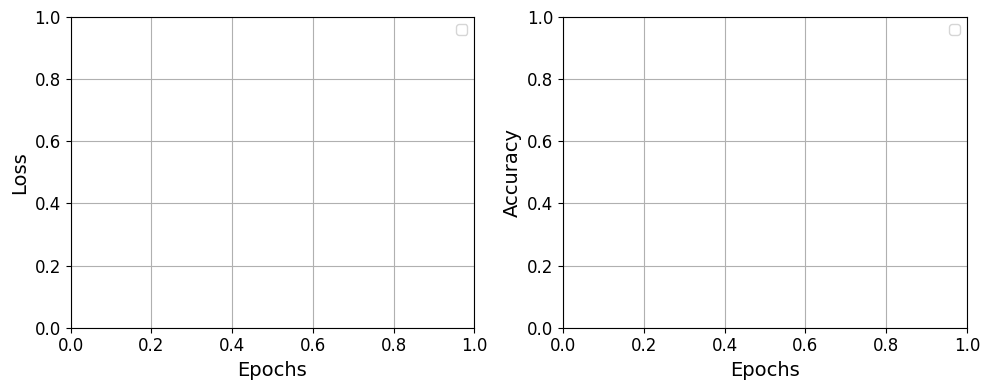

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for model in vgg_results.keys():
    # for phase in vgg_results[model].keys():
    for phase in ["val"]:
        axes[0].plot(
            range(len(vgg_results[model][phase]["loss"])),
            vgg_results[model][phase]["loss"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[0].set_xlabel("Epochs", size=14)
axes[0].set_ylabel("Loss", size=14)
axes[0].tick_params(labelsize=12)
axes[0].grid()
axes[0].legend()

for model in vgg_results.keys():
    # for phase in vgg_results[model].keys():
    for phase in ["val"]:
        axes[1].plot(
            range(len(vgg_results[model][phase]["acc"])),
            vgg_results[model][phase]["acc"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[1].set_xlabel("Epochs", size=14)
axes[1].set_ylabel("Accuracy", size=14)
axes[1].tick_params(labelsize=12)
axes[1].grid()
axes[1].legend()
plt.show()

# 学習したネットワークを保存・ロード

In [ ]:
# # PyTorchのネットワークパラメータの保存
# save_path = "./weights_fine_tuning.pth"
# torch.save(net.state_dict(), save_path)

In [ ]:
# # PyTorchのネットワークパラメータのロード
# load_path = "./weights_fine_tuning.pth"
# load_weights = torch.load(load_path)
# net.load_state_dict(load_weights)

# # GPU上で保存された重みをCPU上でロードする場合
# load_weights = torch.load(load_path, map_location={"cuda:0": "cpu"})
# net.load_state_dict(load_weights)

以上